# 2. Data Preparation / Feature Generation

Now let's prepare the Dataset for further modeling by handling missing values in the Data, fill where possible and then create the combined Features we identified in the last step. 

**What to do**:
- Handle missing Values 
- Generate Features to pick up relevant correlation patterns

In [455]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

In [456]:
def stacked_plot(first, second):
    tab = pd.crosstab(train[first], train[second])
    print(tab)
    tab.div(tab.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True)

In [457]:
# Let's load the Data again
train = pd.read_csv('data/train.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)
combined = pd.read_csv('data/combined.csv', index_col=0)
surv = pd.read_csv('data/survived.csv', index_col=0)
nosurv = pd.read_csv('data/nosurvived.csv', index_col=0)

In [458]:
surv.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## 1. Filling in missing values

Let's first look at the spread of missing values

In [459]:
print('Missing Values in Training Data')
print(train.isnull().sum())

print('\nMissing Values in Test Data')
test.isnull().sum()

Missing Values in Training Data
Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Missing Values in Test Data


Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

We have already seen that Age groups have a significant impact on survival, so we will have to treat them during Feature Engineering and try to recreate as much as possible. 

In [460]:
print('%f Percent of all Cabin Values are missing'%(train.Cabin.isnull().sum()/len(train.Cabin)*100))

77.104377 Percent of all Cabin Values are missing


So we start by filling in the 2 embarked Values

In [461]:
train[train['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Two women traveling 1st Class, survived and where 38 and 62yrs old. This points to 'C'

In [462]:
train['Embarked'].iloc[61] = 'C'
train['Embarked'].iloc[830] = 'C'

C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [463]:
# Imputing the missing Fare
test[test['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


He embarked in 3rd Class in S. Let's look at the price distribution on this subset

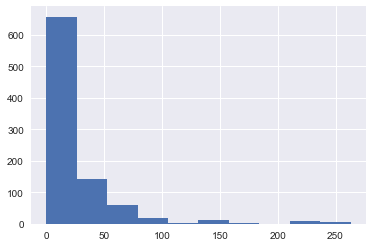

In [464]:
sdata = pd.read_csv('data/train_subdata_departure_S.csv')
sdata['Fare'].hist()

It is highly negatively skewed, let's use the median value

In [465]:
test['Fare'][test['Fare'].isnull()] = sdata['Fare'].median()

C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### 2. Engineering the Features

Let's know implement the Information we have found so far into a set of new features that should hopefully improve our performance on the Dataset. 

In [466]:
# Create the Features on the Training Data
train['Child'] = (train['Age']<10).astype('int')
train['Young'] = ((train['Age'] >= 18) & (train['Age']<=40)).astype('int')
train['Young_m'] = ((train['Age']>= 18) & (train['Age'] <= 40) & (train['Sex']=='male')).astype('int')
train['Young_f'] = ((train['Age']>=18) & (train['Age']<= 40) & (train['Sex']=='female')).astype('int')
train['Cabin_known'] = (train.Cabin.isnull()==False).astype('int')
train['Age_known'] = (train['Age'].isnull() == False).astype('int')
train['Family'] = (train['SibSp'] + train['Parch']).astype('int')
train['Alone'] = ((train['SibSp'] + train['Parch'])==0).astype('int')
train['LargeFamily'] = ((train['SibSp']>2) | (train['Parch']>3)).astype('int')
train['Deck'] = train.Cabin.str[0]
train['Deck'] = train['Deck'].fillna(value='U')
train['Ttype'] = train['Ticket'].str[0]
train['Title'] = train['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

In [467]:
# Create the Features on the Test Data
test['Child'] = (test['Age']<10).astype('int')
test['Young'] = ((test['Age'] >= 18) & (test['Age']<=40)).astype('int')
test['Young_m'] = ((test['Age']>= 18) & (test['Age'] <= 40) & (test['Sex']=='male')).astype('int')
test['Young_f'] = ((test['Age']>=18) & (test['Age']<= 40) & (test['Sex']=='female')).astype('int')
test['Cabin_known'] =( test['Cabin'] == False).astype('int')
test['Age_known'] = (test['Age'].isnull() == False).astype('int')
test['Family'] = (test['SibSp'] + test['Parch']).astype('int')
test['Alone'] = ((test['SibSp'] + test['Parch'])==0).astype('int')
test['LargeFamily'] = ((test['SibSp']>2) | (test['Parch']>3)).astype('int')
test['Deck'] = test.Cabin.str[0]
test['Deck'] = test['Deck'].fillna(value='U')
test['Ttype'] = test['Ticket'].str[0]
test['Title'] = test['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

In [468]:
train.Deck.unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [469]:
test.Deck.unique()

array(['U', 'B', 'E', 'A', 'C', 'D', 'F', 'G'], dtype=object)

#### Testing the new Features for precision and significance


#### Child

Survived    0    1
Child             
0         525  304
1          24   38


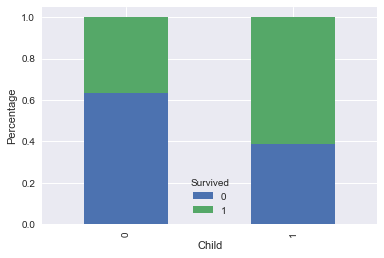

In [470]:
stacked_plot('Child', 'Survived')
plt.xlabel('Child');
plt.ylabel('Percentage');

Pclass    1    2    3
Child                
0       213  167  449
1         3   17   42


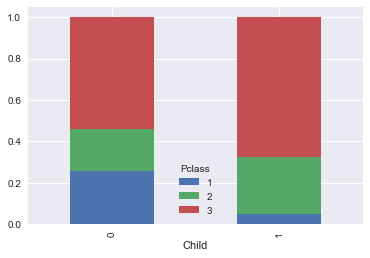

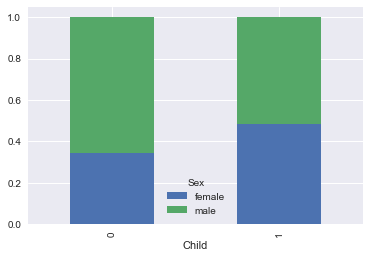

In [471]:
tab = pd.crosstab(train['Child'], train['Pclass'])
print(tab)
tab.div(tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
tab = pd.crosstab(train['Child'], train['Sex'])
tab.div(tab.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True)

###  The 'Young' Feature

Beeing between 18-40 overall has no influence on survival, because the effect swaps based on gender.
That seems like a very interesting feature as it would most likely not be picked up automatically by an algorithm. 


Survived    0    1
Young             
0         272  168
1         277  174


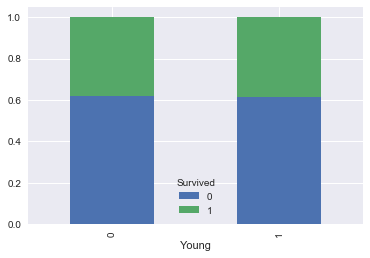

In [472]:
young = pd.crosstab(train['Young'], train['Survived'])
print(young)
young.div(young.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True)

Survived    0    1
Young_m           
0         308  290
1         241   52
Survived    0    1
Young_f           
0         513  220
1          36  122


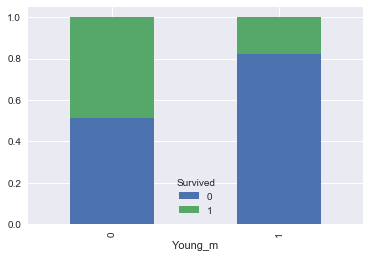

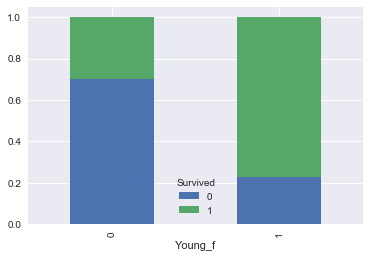

In [473]:
# Survival as young Male
young = pd.crosstab(train['Young_m'], train['Survived'])
print(young)
young.div(young.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True)

# Survival as young Female
young = pd.crosstab(train['Young_f'], train['Survived'])
print(young)
young.div(young.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True)

### Cabin

- It proofed more likely to know the Cabin Number of an Survivor. 
- It is slighly more likely to know the Cabin Number of a Woman, but this again is well explained by their higher survival chance overall.

Survived       0    1
Cabin_known          
0            481  206
1             68  136


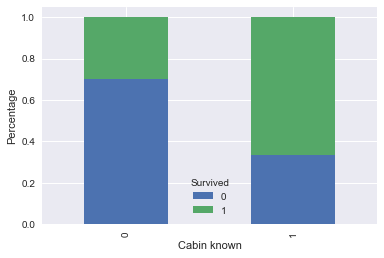

In [474]:
cab = pd.crosstab(train['Cabin_known'], train['Survived'])
print(cab)
cab.div(cab.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True);
plt.xlabel('Cabin known');
plt.ylabel('Percentage');

Sex          female  male
Cabin_known              
0               217   470
1                97   107

 Pclass         1    2    3
Cabin_known               
0             40  168  479
1            176   16   12


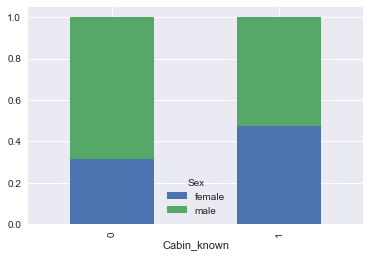

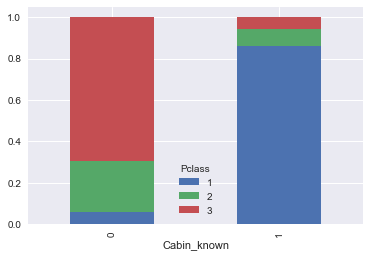

In [475]:
cab = pd.crosstab(train['Cabin_known'], train['Sex'])
print(cab)
cab.div(cab.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True);

cab = pd.crosstab(train['Cabin_known'], train['Pclass'])
print('\n',cab)
cab.div(cab.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True);

### Deck

Survived    0    1
Deck              
A           8    7
B          12   35
C          24   35
D           8   25
E           8   24
F           5    8
G           2    2
T           1    0
U         481  206


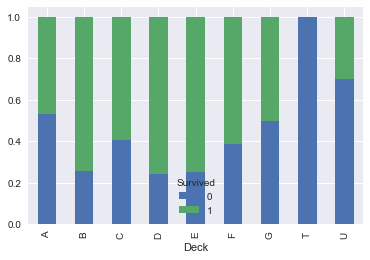

In [476]:
cab = pd.crosstab(train['Deck'], train['Survived'])
print(cab)
cab.div(cab.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True)

In [477]:
pd.crosstab(train['Deck'], train['Cabin_known'])

Cabin_known,0,1
Deck,,
A,0,15
B,0,47
C,0,59
D,0,33
E,0,32
F,0,13
G,0,4
T,0,1
U,687,0


Survived    0    1
Deck              
A           8    7
B          12   35
C          24   35
D           8   25
E           8   24
F           5    8
G           2    2
T           1    0
U         481  206


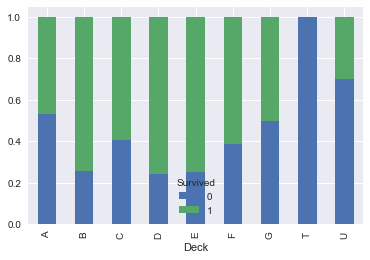

In [478]:
deck = pd.crosstab(train['Deck'], train['Survived'])
print(deck)
deck.div(deck.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True);

In [479]:
stats.binom_test(x=12, n=12+35, p=24/(24.+35.))

0.037415527401218264

### Ticket Number

In [480]:
pd.concat([train, test]).Ttype.unique()

array(['A', 'P', 'S', '1', '3', '2', 'C', '7', 'W', '4', 'F', 'L', '9',
       '6', '5', '8'], dtype=object)

Survived    0   1
Ttype            
1          54  92
2          98  85
3         229  72
4           8   2
5           3   0
6           5   1
7           8   1
8           2   0
9           0   1
A          27   2
C          31  16
F           3   4
L           3   1
P          23  42
S          44  21
W          11   2


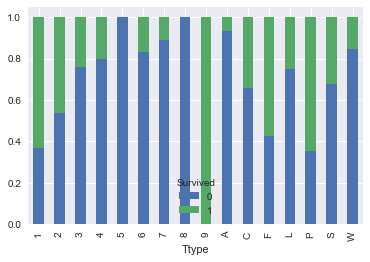

In [481]:
ticket = pd.crosstab(train['Ttype'], train['Survived'])
print(ticket)
ticket.div(ticket.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True)

There are tickets that show a significant lower survival rate. We can package those into new features.

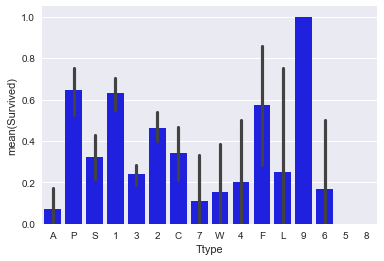

In [482]:
sns.barplot(x="Ttype", y="Survived", data=train, ci=95.0, color="blue");

In [483]:
train['Bad_ticket'] = train['Ttype'].isin(['A', '3', '7', 'W', '4', 'L', '6'])
test['Bad_ticket'] = test['Ttype'].isin(['A', '3', '7', 'W', '4', 'L', '6'])

Survived      0    1
Bad_ticket          
False       258  261
True        291   81


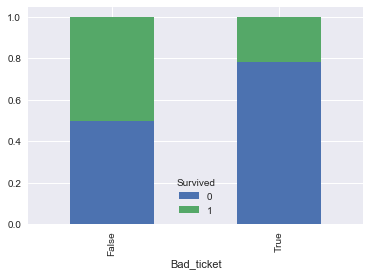

In [484]:
tab = pd.crosstab(train['Bad_ticket'], train['Survived'])
print(tab)
tab.div(tab.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True);

Bad_ticket  False  True 
Deck                    
A              14      1
B              44      3
C              56      3
D              24      9
E              28      4
F               9      4
G               2      2
T               1      0
U             341    346


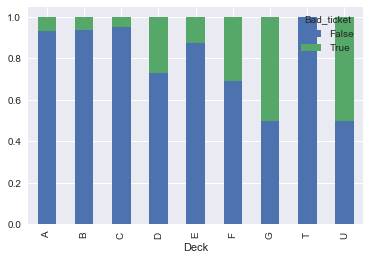

In [485]:
stacked_plot('Deck', 'Bad_ticket')

### 'Age known'

Age knows shows a statistically significant difference, but it seems it is most likely moderated by the Passenger Class

Survived     0    1
Age_known          
0          125   52
1          424  290


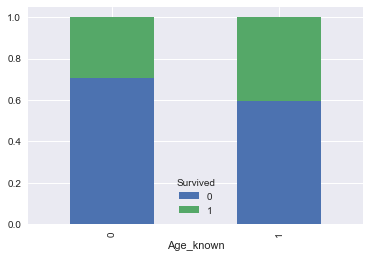

In [486]:
stacked_plot('Age_known', 'Survived')

In [487]:
stats.binom_test(x=424,n=424+290,p=125/(125.+52.))

1.5623264542193693e-10

Pclass       1    2    3
Age_known               
0           30   11  136
1          186  173  355


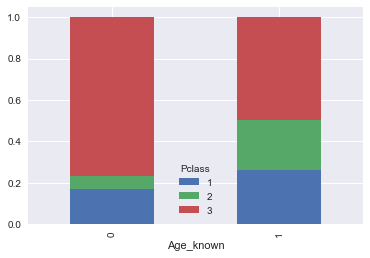

In [488]:
stacked_plot('Age_known', 'Pclass')

Sex        female  male
Age_known              
0              53   124
1             261   453


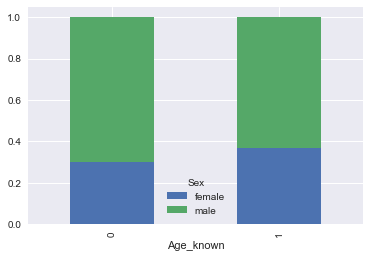

In [489]:
stacked_plot('Age_known', 'Sex')

### Family

Again our first impression is reinforced, the highest chances of survival are between 1-3 Siblings. Afterwards your chances drop significantly.

Survived    0    1
Family            
0         374  163
1          72   89
2          43   59
3           8   21
4          12    3
5          19    3
6           8    4
7           6    0
10          7    0


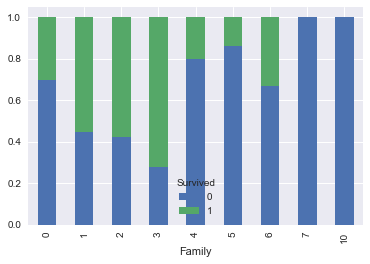

In [490]:
stacked_plot('Family', 'Survived')

### 'Alone'

Most people traveling alone are men and 3rd Class, which explains their lower survival rate.

Survived    0    1
Alone             
0         175  179
1         374  163


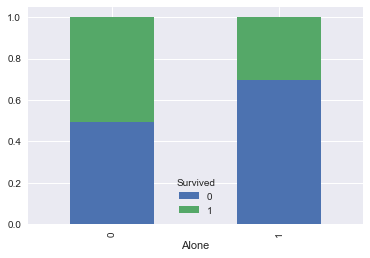

In [491]:
stacked_plot('Alone', 'Survived')

Sex    female  male
Alone              
0         188   166
1         126   411


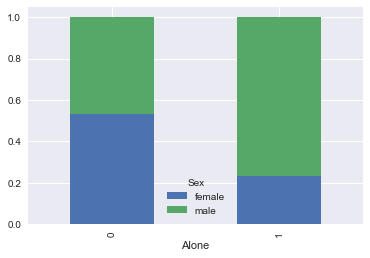

In [492]:
stacked_plot('Alone', 'Sex')

Pclass    1    2    3
Alone                
0       107   80  167
1       109  104  324


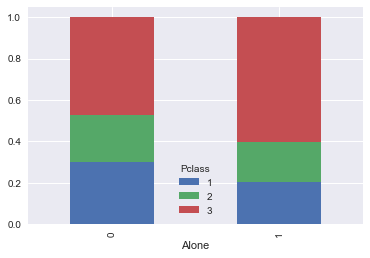

In [493]:
stacked_plot('Alone', 'Pclass')

In [494]:
train.keys()

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Child', 'Young', 'Young_m', 'Young_f',
       'Cabin_known', 'Age_known', 'Family', 'Alone', 'LargeFamily', 'Deck',
       'Ttype', 'Title', 'Bad_ticket'],
      dtype='object')

### Large Family

Survived       0    1
LargeFamily          
0            501  334
1             48    8


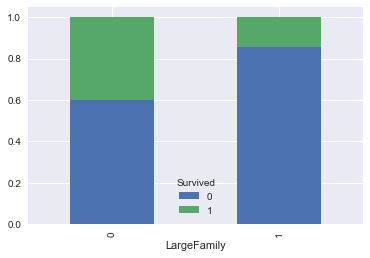

In [495]:
stacked_plot('LargeFamily', 'Survived')

Pclass         1    2    3
LargeFamily               
0            212  183  440
1              4    1   51


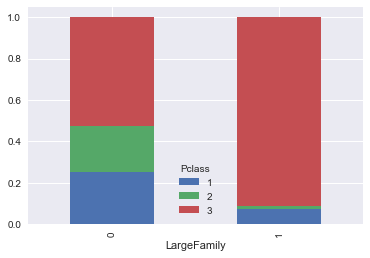

In [496]:
stacked_plot('LargeFamily', 'Pclass')

### Names

In [497]:
dummy = pd.concat([train.drop('Survived',1), test])
print(dummy['Age'].groupby(dummy['Title']).count())
print(dummy['Age'].groupby(dummy['Title']).mean())

Title
Capt              1
Col               4
Don               1
Dona              1
Dr                7
Jonkheer          1
Lady              1
Major             2
Master           53
Miss            210
Mlle              2
Mme               1
Mr              581
Mrs             170
Ms                1
Rev               8
Sir               1
the Countess      1
Name: Age, dtype: int64
Title
Capt            70.000000
Col             54.000000
Don             40.000000
Dona            39.000000
Dr              43.571429
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           5.482642
Miss            21.774238
Mlle            24.000000
Mme             24.000000
Mr              32.252151
Mrs             36.994118
Ms              28.000000
Rev             41.250000
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64


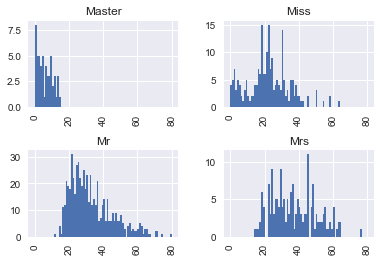

In [498]:
dummy2 = dummy[dummy['Title'].isin(['Master', 'Mr', 'Miss', 'Mrs'])]
dummy2['Age'].hist(by=dummy2['Title'], bins=np.arange(0,81,1));

Master / Mr is capturing the Relation between male childre/teenager and grownups very well. With Miss and Mrs the overlap is more substantial

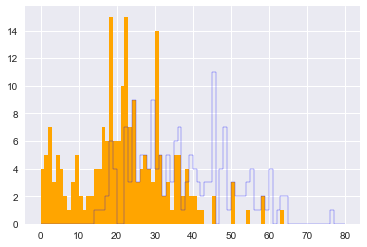

In [499]:
miss = dummy[dummy['Title']=='Miss']
mrs = dummy[dummy['Title']=='Mrs']

plt.hist(miss['Age'].dropna().values, color='orange', bins=np.arange(0,81,1));
plt.hist(mrs['Age'].dropna().values, histtype='step', color='blue', bins=np.arange(0,81,1));

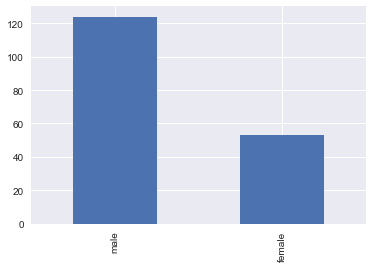

In [500]:
train['Sex'][train['Age'].isnull()].value_counts().plot(kind='bar')

In [501]:
# Filling in the male values using the Distinction Mr/Master to distinguish Young_m from Grownup
train['Child'][(train['Sex']=='male') & (train['Title']=='Master') &(train['Age'].isnull())] = 1
train['Age'][(train['Sex']=='male') & (train['Title']=='Master') &(train['Age'].isnull())] = train['Age'][(train['Sex']=='male')&(train['Young']==1)].mean()

C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Let's look at the Age distributions for females to find something to help us better approximate the most important survival decission for women. Are you between 18-40 or not..

In [502]:
missing_fem = train[(train['Sex']=='female') & (train['Age'].isnull())]
missing_fem.Pclass.value_counts()

3    42
1     9
2     2
Name: Pclass, dtype: int64

Most our missing values are in the third class. I would assume that the title 'Mrs' actually indicates a not yet married woman, which a lower income person most likely could not sustain for long. Let's see if our data reflects this class related use of the Title.

In [503]:
# Calculate Mean Ages
miss_avg_1 = train['Age'][(train['Sex']=='female')&(train['Pclass']==1)&(train['Title']=='Miss')].mean()
miss_avg_2 = train['Age'][(train['Sex']=='female')&(train['Pclass']==2)&(train['Title']=='Miss')].mean()
miss_avg_3 = train['Age'][(train['Sex']=='female')&(train['Pclass']==3)&(train['Title']=='Miss')].mean()

mrs_avg_1 = train['Age'][(train['Sex']=='female')&(train['Pclass']==1)&(train['Title']=='Mrs')].mean()
mrs_avg_2 = train['Age'][(train['Sex']=='female')&(train['Pclass']==2)&(train['Title']=='Mrs')].mean()
mrs_avg_3 = train['Age'][(train['Sex']=='female')&(train['Pclass']==3)&(train['Title']=='Mrs')].mean()

print(miss_avg_1, miss_avg_2, miss_avg_3)
print(mrs_avg_1, mrs_avg_2, mrs_avg_3)

30.0 22.390625 16.1231884058
40.8823529412 33.6829268293 33.5151515152


Mean Age per Class (3-1):
16.1231884058
22.390625
30.0
Age Std per Class(3-1):
9.69731459079
13.3747079407
12.8523078932


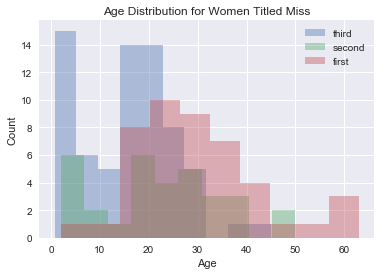

In [504]:
# First we look at the mean age values per class
print('Mean Age per Class (3-1):')
print(train['Age'][(train['Sex']=='female')&(train['Pclass']==3)&(train['Title']=='Miss')].mean())
print(train['Age'][(train['Sex']=='female')&(train['Pclass']==2)&(train['Title']=='Miss')].mean())
print(train['Age'][(train['Sex']=='female')&(train['Pclass']==1)&(train['Title']=='Miss')].mean())
print('Age Std per Class(3-1):')
print(train['Age'][(train['Sex']=='female')&(train['Pclass']==3)&(train['Title']=='Miss')].std())
print(train['Age'][(train['Sex']=='female')&(train['Pclass']==2)&(train['Title']=='Miss')].std())
print(train['Age'][(train['Sex']=='female')&(train['Pclass']==1)&(train['Title']=='Miss')].std())

# Plotting 'Miss'
train['Age'][(train['Sex']=='female')&(train['Pclass']==3)&(train['Title']=='Miss')].hist(alpha=0.4, label='3rd')
train['Age'][(train['Sex']=='female')&(train['Pclass']==2)&(train['Title']=='Miss')].hist(alpha=0.4, label='2nd')
train['Age'][(train['Sex']=='female')&(train['Pclass']==1)&(train['Title']=='Miss')].hist(alpha=0.4, label='1st')
plt.legend(['third', 'second', 'first']);
plt.title('Age Distribution for Women Titled Miss');
plt.xlabel('Age');
plt.ylabel('Count');

Mean Age per Class (3-1):
33.5151515152
33.6829268293
40.8823529412
Age Std per Class(3-1):
10.0315789264
10.3185246629
12.643754491


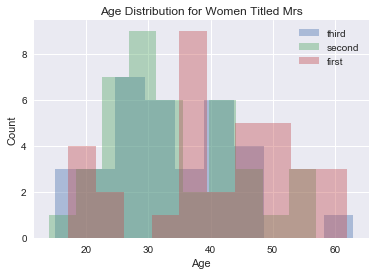

In [505]:
# First we look at the mean age values per class
print('Mean Age per Class (3-1):')
print(train['Age'][(train['Sex']=='female')&(train['Pclass']==3)&(train['Title']=='Mrs')].mean())
print(train['Age'][(train['Sex']=='female')&(train['Pclass']==2)&(train['Title']=='Mrs')].mean())
print(train['Age'][(train['Sex']=='female')&(train['Pclass']==1)&(train['Title']=='Mrs')].mean())
print('Age Std per Class(3-1):')
print(train['Age'][(train['Sex']=='female')&(train['Pclass']==3)&(train['Title']=='Mrs')].std())
print(train['Age'][(train['Sex']=='female')&(train['Pclass']==2)&(train['Title']=='Mrs')].std())
print(train['Age'][(train['Sex']=='female')&(train['Pclass']==1)&(train['Title']=='Mrs')].std())

# Plotting 'Mrs'
train['Age'][(train['Sex']=='female')&(train['Pclass']==3)&(train['Title']=='Mrs')].hist(alpha=0.4, label='3rd')
train['Age'][(train['Sex']=='female')&(train['Pclass']==2)&(train['Title']=='Mrs')].hist(alpha=0.4, label='2nd')
train['Age'][(train['Sex']=='female')&(train['Pclass']==1)&(train['Title']=='Mrs')].hist(alpha=0.4, label='1st')
plt.legend(['third', 'second', 'first'])
plt.title('Age Distribution for Women Titled Mrs')
plt.xlabel('Age')
plt.ylabel('Count')

It seems there is a helpfull difference in the Useage of the Titles between the classes. 
Without misslabeling too many people, we can assume:
- 1st Class: Miss(Young_f)
- 2nd Class: Miss is too evenly spread to be of any use
- 3rd Class: Miss for children, and Mrs following afterward

In [506]:
train.keys()

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Child', 'Young', 'Young_m', 'Young_f',
       'Cabin_known', 'Age_known', 'Family', 'Alone', 'LargeFamily', 'Deck',
       'Ttype', 'Title', 'Bad_ticket'],
      dtype='object')

In order to make use of the difference in Age based on 'Pclass' i am implementing them manually over the already labeled 'Young_f', 'Young_m' classes. As those pick up the most relevant trend in survival based on Age as moderated by 'Sex'.

I am picking out the missing values based on 'Pclass' and 'Title' and set their Categories, and impute 'Age' on the mean Average Values for the use of that title in the respective class.

In [507]:
# Implementing for 1st Class
train['Young_f'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==1)&(train['Title']=='Miss')] = 1
train['Young'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==1)&(train['Title']=='Miss')] = 1
train['Age'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==1)&(train['Title']=='Miss')] = miss_avg_1

train['Young_f'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==1)&(train['Title']=='Mrs')] = 0
train['Young'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==1)&(train['Title']=='Mrs')] = 0
train['Age'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==1)&(train['Title']=='Mrs')] = mrs_avg_1


C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after r

In [508]:
# Implementing for 1st Class
test['Young_f'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==1)&(test['Title']=='Miss')] = 1
test['Young'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==1)&(test['Title']=='Miss')] = 1
test['Age'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==1)&(test['Title']=='Miss')] = miss_avg_1

test['Young_f'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==1)&(test['Title']=='Mrs')] = 0
test['Young'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==1)&(test['Title']=='Mrs')] = 0
test['Age'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==1)&(test['Title']=='Mrs')] = mrs_avg_1


C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after r

In [509]:
# Imputing 3rd Class 'Mrs
train['Young_f'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==3)&(train['Title']=='Mrs')] = 1
train['Young'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==3)&(train['Title']=='Mrs')] = 1
# Fill in the mean values
train['Age'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==3)&(train['Title']=='Mrs')] = mrs_avg_3

# Imputing 3rd Class 'Miss'
train['Young_f'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==3)&(train['Title']=='Miss')] = 0
train['Child'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==3)&(train['Title']=='Miss')] = 1
train['Age'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==3)&(train['Title']=='Miss')] = miss_avg_3


C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\

In [510]:
# Imputing 3rd Class 'Mrs
test['Young_f'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==3)&(test['Title']=='Mrs')] = 1
test['Young'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==3)&(test['Title']=='Mrs')] = 1
# Fill in the mean values
test['Age'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==3)&(test['Title']=='Mrs')] = mrs_avg_3

# Imputing 3rd Class 'Miss'
test['Young_f'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==3)&(test['Title']=='Miss')] = 0
test['Child'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==3)&(test['Title']=='Miss')] = 1
test['Age'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==3)&(test['Title']=='Miss')] = miss_avg_3


C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\

In [511]:
# Imputing 2nd Class 'Mrs
train['Young_f'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==3)&(train['Title']=='Mrs')] = 1
train['Young'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==3)&(train['Title']=='Mrs')] = 1
# Fill in the mean values
train['Age'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==3)&(train['Title']=='Mrs')] = mrs_avg_3

# Imputing 3rd Class 'Miss'
train['Young_f'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==3)&(train['Title']=='Miss')] = 0
train['Child'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==3)&(train['Title']=='Miss')] = 1
train['Age'][(train['Sex']=='female')&(train['Age'].isnull())&(train['Pclass']==3)&(train['Title']=='Miss')] = miss_avg_3


C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\

In [512]:
# Imputing 2nd Class 'Mrs
test['Young_f'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==3)&(test['Title']=='Mrs')] = 1
test['Young'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==3)&(test['Title']=='Mrs')] = 1
# Fill in the mean values
test['Age'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==3)&(test['Title']=='Mrs')] = mrs_avg_3

# Imputing 3rd Class 'Miss'
test['Young_f'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==3)&(test['Title']=='Miss')] = 0
test['Child'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==3)&(test['Title']=='Miss')] = 1
test['Age'][(test['Sex']=='female')&(test['Age'].isnull())&(test['Pclass']==3)&(test['Title']=='Miss')] = miss_avg_3


C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\frank\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\

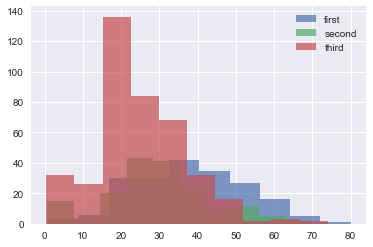

In [513]:
train['Age'][train['Pclass']==1].hist(alpha=0.7)
train['Age'][train['Pclass']==2].hist(alpha=0.7)
train['Age'][train['Pclass']==3].hist(alpha=0.7)
plt.legend(['first', 'second', 'third'])

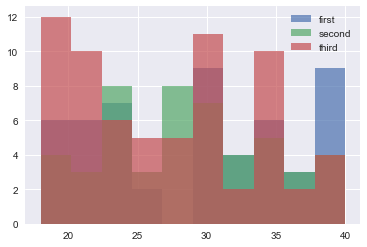

In [514]:
train['Age'][(train['Young_f']==1)&(train['Pclass']==1)].hist(alpha=0.7)
train['Age'][(train['Young_f']==1)&(train['Pclass']==2)].hist(alpha=0.7)
train['Age'][(train['Young_f']==1)&(train['Pclass']==3)].hist(alpha=0.7)
plt.legend(['first', 'second', 'third'])

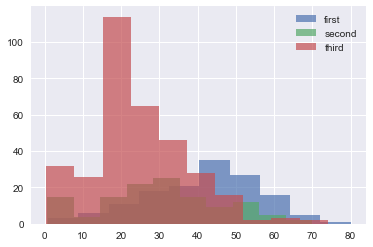

In [515]:
train['Age'][(train['Young_f']==0)&(train['Pclass']==1)].hist(alpha=0.7)
train['Age'][(train['Young_f']==0)&(train['Pclass']==2)].hist(alpha=0.7)
train['Age'][(train['Young_f']==0)&(train['Pclass']==3)].hist(alpha=0.7)
plt.legend(['first', 'second', 'third'])

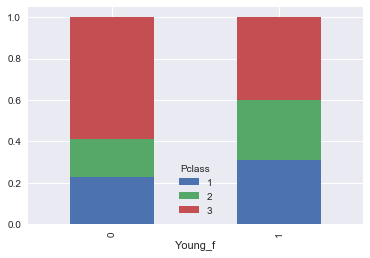

In [516]:
tab = pd.crosstab(train['Young_f'], train['Pclass'])
tab.div(tab.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True)

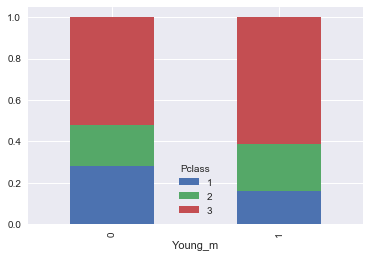

In [517]:
tab = pd.crosstab(train['Young_m'], train['Pclass'])
tab.div(tab.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True)

### Fare

Let's model the Fare as an ordinal integer variable based on the logarithmic fare values:

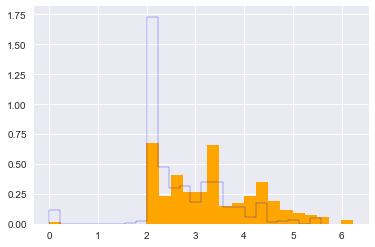

In [518]:
plt.hist(np.log(surv['Fare'].values+1), color='orange', normed=True, bins=25);
plt.hist(np.log(nosurv['Fare'].values+1), color='blue', histtype='step', normed=True, bins=25);

In [519]:
pd.DataFrame(np.floor(np.log10(train['Fare']+1))).astype('int')[:3]

,Fare
PassengerId,
1,0
2,1
3,0


Survived    0    1
Fare_cat          
0         249   62
1         286  241
2          14   39


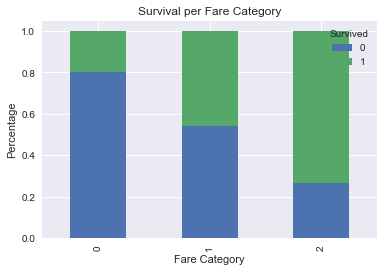

In [520]:
train['Fare_cat'] = pd.DataFrame(np.floor(np.log10(train['Fare'] + 1))).astype('int')
test['Fare_cat'] = pd.DataFrame(np.floor(np.log10(test['Fare'] + 1))).astype('int')

stacked_plot('Fare_cat', 'Survived')
plt.xlabel('Fare Category');
plt.ylabel('Percentage');
plt.title('Survival per Fare Category');


## 4. Preparing Data for Machine Learning usage

We have to adjust the column types to integers, as most machine learning systems can not handle string input.

In [521]:
train['Sex'] = train['Sex'].astype('category')
train['Sex'].cat.categories = [0,1]
train['Sex'] = train['Sex'].astype('int')
train['Ticket'] = train['Ticket'].astype('category')
train['Cabin'] = train['Cabin'].astype('category')
train['Embarked'] = train['Embarked'].astype('category')
train['Embarked'].cat.categories = [0,1,2]
train['Embarked'] = train['Embarked'].astype('int')
train['Deck'] = train['Deck'].astype('category')
train['Deck'].cat.categories = [0,1,2,3,4,5,6,7,8]
train['Deck'] = train['Deck'].astype('int')
train['Bad_ticket'] = train['Bad_ticket'].astype('int')

In [522]:
test['Sex'] = test['Sex'].astype('category')
test['Sex'].cat.categories = [0,1]
test['Sex'] = test['Sex'].astype('int')
test['Ticket'] = test['Ticket'].astype('category')
test['Cabin'] = test['Cabin'].astype('category')
test['Embarked'] = test['Embarked'].astype('category')
test['Embarked'].cat.categories = [0,1,2]
test['Embarked'] = test['Embarked'].astype('int')
test['Deck'] = test['Deck'].astype('category')
test['Deck'].cat.categories = [0,1,2,3,4,5,6,7]
test['Deck'] = test['Deck'].astype('int')
test['Bad_ticket'] = test['Bad_ticket'].astype('int')

In [523]:
train.dtypes

Survived          int64
Pclass            int64
Name             object
Sex               int32
Age             float64
SibSp             int64
Parch             int64
Ticket         category
Fare            float64
Cabin          category
Embarked          int32
Child             int32
Young             int32
Young_m           int32
Young_f           int32
Cabin_known       int32
Age_known         int32
Family            int32
Alone             int32
LargeFamily       int32
Deck              int32
Ttype            object
Title            object
Bad_ticket        int32
Fare_cat          int32
dtype: object

In [529]:
# Drop unnecessary Features we used for Calculating secondary Features
train_final = train.drop(['Name','Ticket','Ttype', 'Title', 'Cabin'],axis=1)
test_final = test.drop(['Name', 'Ticket', 'Ttype', 'Title', 'Cabin'], axis=1)

In [532]:
# Test if all data is identical in label and datatype
all(train_final.drop('Survived', axis=1).dtypes == test_final.dtypes)

True

In [533]:
# Export Dataset
train_final.to_csv('data/train_clean.csv')
test_final.to_csv('data/test_clean.csv')